# Fraud Scoring & Business Impact Analysis

### Objective

The goal of this notebook is to simulate how a fraud detection model would be used in a real business environment.

Instead of focusing only on model performance metrics, we aim to:

- Convert predicted probabilities into fraud scores

- Group transactions into risk levels

- Analyze business costs associated with model decisions

- Identify the optimal decision threshold from a financial perspective

This notebook closes the full analytics lifecycle:

    Model → Decision → Business Impact

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

import joblib

sns.set_theme(style="whitegrid")


## Load Data & Model

In [3]:
df = pd.read_csv('../data/creditcard.csv')

# Feature / target split
X = df.drop(columns=['Class'])
y = df['Class']

# Load trained best model from Notebook 02
best_model = joblib.load('../models/best_model.pkl')

## Fraud Probability & Scoring

In [4]:
# Predict probabilities
y_proba = best_model.predict_proba(X)[:, 1]

# Create scoring dataframe
scoring_df = X.copy()
scoring_df['fraud_probability'] = y_proba
scoring_df['fraud_score'] = (y_proba * 100).round(2)

scoring_df[['fraud_probability', 'fraud_score']].head()

,fraud_probability,fraud_score
0,0.000287,0.03
1,0.000287,0.03
2,0.000287,0.03
3,0.000287,0.03
4,0.000287,0.03


Interpretation

- Fraud score ranges from 0 to 100
- Higher score = higher risk
- Score ≠ decision (threshold comes later)

## Risk Level Categorization

In [5]:
def risk_bucket(p):
    if p < 0.2:
        return 'Low Risk'
    elif p < 0.5:
        return 'Medium Risk'
    else:
        return 'High Risk'

scoring_df['risk_level'] = scoring_df['fraud_probability'].apply(risk_bucket)


In [6]:
scoring_df['risk_level'].value_counts(normalize=True)

risk_level
Low Risk       0.999199
High Risk      0.000586
Medium Risk    0.000214
Name: proportion, dtype: float64

## Risk Distribution Interpretation

The risk distribution chart shows a strong concentration of transactions classified as *Low Risk*.

This behavior is expected and reflects the extreme class imbalance present in real-world fraud detection datasets, where fraudulent transactions represent a very small fraction of the total volume.

Since the majority of predicted fraud probabilities are below 0.2, most transactions naturally fall into the *Low Risk* category when using the following risk segmentation:

- Low Risk: probability < 0.2
- Medium Risk: 0.2 ≤ probability < 0.5
- High Risk: probability ≥ 0.5

Therefore, the dominance of the *Low Risk* group is not a visualization issue, but a realistic representation of transaction behavior in large-scale financial systems.


<Axes: xlabel='risk_level', ylabel='count'>

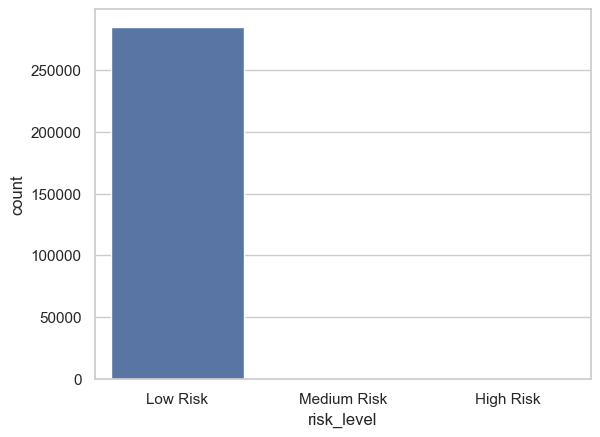

In [7]:
sns.countplot(
    data=scoring_df,
    x='risk_level',
    order=['Low Risk', 'Medium Risk', 'High Risk']
)

## Threshold Sensitivity Analysis

In [8]:
thresholds = np.arange(0.1, 0.9, 0.05)
metrics = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    metrics.append({
        'threshold': t,
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1_score': f1_score(y, y_pred),
        'false_positives': fp,
        'false_negatives': fn
    })

metrics_df = pd.DataFrame(metrics)
metrics_df


,threshold,precision,recall,f1_score,false_positives,false_negatives
0,0.10,0.369077,0.300813,0.331467,253,344
1,0.15,0.542125,0.300813,0.386928,125,344
2,0.20,0.649123,0.300813,0.411111,80,344
3,0.25,0.696078,0.288618,0.408046,62,350
4,0.30,0.715026,0.280488,0.402920,55,354
5,0.35,0.684524,0.233740,0.348485,53,377
6,0.40,0.684524,0.233740,0.348485,53,377
7,0.45,0.688623,0.233740,0.349014,52,377
8,0.50,0.688623,0.233740,0.349014,52,377
9,0.55,0.692771,0.233740,0.349544,51,377


## Precision vs Recall Trade-off

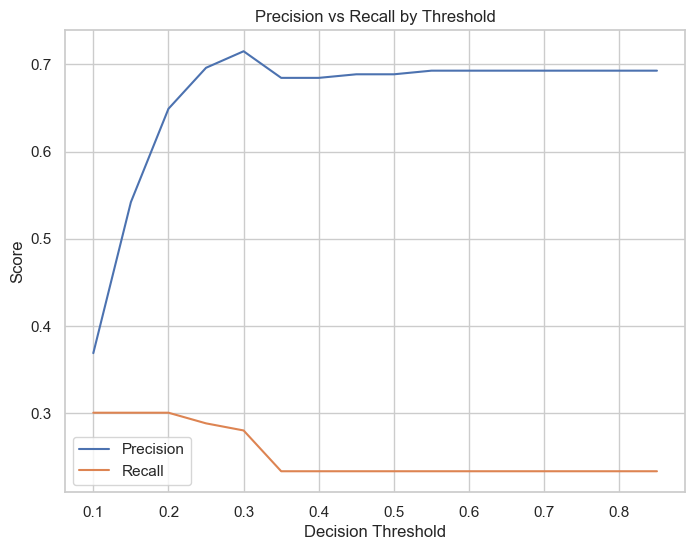

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision')
plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall by Threshold')
plt.legend()
plt.show()

Insight

- Lower threshold → higher recall (fewer missed frauds)
- Higher threshold → higher precision (fewer false alerts)

## Business Cost Simulation

| Error Type                    | Cost |
| ----------------------------- | ---- |
| False Negative (missed fraud) | $500 |
| False Positive (wrong block)  | $5   |


In [10]:
COST_FN = 500
COST_FP = 5

metrics_df['business_cost'] = (
    metrics_df['false_negatives'] * COST_FN +
    metrics_df['false_positives'] * COST_FP
)

metrics_df[['threshold', 'business_cost']]


,threshold,business_cost
0,0.10,173265
1,0.15,172625
2,0.20,172400
3,0.25,175310
4,0.30,177275
5,0.35,188765
6,0.40,188765
7,0.45,188760
8,0.50,188760
9,0.55,188755


## Cost vs Threshold

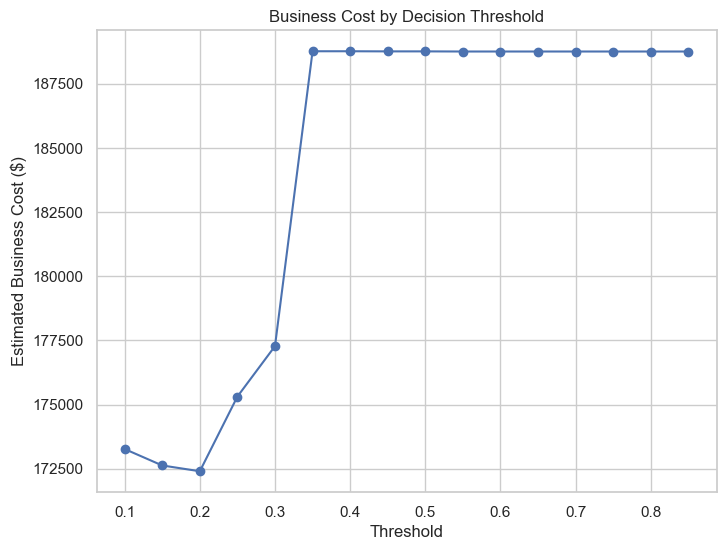

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(metrics_df['threshold'], metrics_df['business_cost'], marker='o')
plt.xlabel('Threshold')
plt.ylabel('Estimated Business Cost ($)')
plt.title('Business Cost by Decision Threshold')
plt.show()

## Optimal Threshold Selection

In [12]:
optimal_row = metrics_df.loc[metrics_df['business_cost'].idxmin()]
optimal_row

threshold               0.200000
precision               0.649123
recall                  0.300813
f1_score                0.411111
false_positives        80.000000
false_negatives       344.000000
business_cost      172400.000000
Name: 2, dtype: float64

Recommended Threshold:

In [13]:
optimal_threshold = optimal_row['threshold']
optimal_threshold

np.float64(0.20000000000000004)

## Business Interpretation

- The default decision threshold of 0.5 is not optimal for fraud detection.
- Lower thresholds significantly reduce costly false negatives, even if they increase false positives.
- The best model decision is not the one that maximizes accuracy, but the one that minimizes total financial loss.

Although a threshold of 0.5 is commonly used in classification problems, it proves to be suboptimal in highly imbalanced scenarios such as fraud detection.

By incorporating business costs into the decision process, we observe that lower thresholds lead to a substantially lower overall financial impact, aligning model decisions with real-world risk management objectives.

## Final Note

This notebook demonstrates how machine learning models can be effectively:

- Interpreted beyond traditional performance metrics
- Operationalized through decision thresholds
- Aligned with real-world business objectives

By shifting the focus from pure accuracy to financial impact, we close the analytics lifecycle:

**From data to dollars.**